## Data:

In [1]:
import glob
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from hmmlearn.hmm import GMMHMM
from sklearn.cluster import KMeans
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

In [2]:
# Import data into dataframes
dfs = []
files = glob.glob('D:\\CL\\*.csv')
for file in files:
    df = pd.read_csv(file,
                     index_col=0,
                     header=None,
                     names=('Date', 'High', 'Low', 'Close', 'Ignore'))
    df.index = pd.to_datetime(df.index, format='%Y%m%d%H%M%S')
    dfs.append(df.iloc[:, :-1])
dfs = pd.concat([dfs[i] for i in range(len(dfs))])

Only using data from the first range (CLZ6, 2016-11-01 to 2016-11-16)

In [3]:
df = dfs.loc[:pd.to_datetime('2016-11-16 15:59:59')]
df.head()
df.tail()

,High,Low,Close
Date,,,
2016-10-31 17:00:00,46.820000,46.71,46.7600
2016-10-31 17:00:01,46.810000,46.72,46.7975
2016-10-31 17:00:02,46.813333,46.69,46.7600
2016-10-31 17:00:03,46.775000,46.76,46.7750
2016-10-31 17:00:04,46.775000,46.76,46.7600


,High,Low,Close
Date,,,
2016-11-16 15:59:55,45.325000,45.325000,45.325000
2016-11-16 15:59:56,45.336000,45.320000,45.336000
2016-11-16 15:59:57,45.336000,45.330000,45.335000
2016-11-16 15:59:58,45.335000,45.326667,45.326667
2016-11-16 15:59:59,45.334545,45.326667,45.331818


Training data will be first 98% of dataset. <br>

In [4]:
# Create training data
train_index = len(df) * 98 // 100
df_train = df.iloc[:train_index]

df_train.head()
df_train.tail()
df_train.shape

,High,Low,Close
Date,,,
2016-10-31 17:00:00,46.820000,46.71,46.7600
2016-10-31 17:00:01,46.810000,46.72,46.7975
2016-10-31 17:00:02,46.813333,46.69,46.7600
2016-10-31 17:00:03,46.775000,46.76,46.7750
2016-10-31 17:00:04,46.775000,46.76,46.7600


,High,Low,Close
Date,,,
2016-11-16 10:28:43,45.830000,45.808571,45.811304
2016-11-16 10:28:44,45.811818,45.807826,45.811692
2016-11-16 10:28:45,45.820000,45.810000,45.811935
2016-11-16 10:28:46,45.812121,45.807609,45.808372
2016-11-16 10:28:47,45.816286,45.808182,45.816286


(973728, 3)

Features are relative differences <br>
$$\left(\frac{close-open}{open}, \frac{high-open}{open}, \frac{open-low}{open}\right)$$

In [5]:
p_open = np.asarray(df_train.iloc[0:-1]['Close'])
p_close = np.asarray(df_train.iloc[1:]['Close'])
p_high = np.asarray(df_train.iloc[1:]['High'])
p_low = np.asarray(df_train.iloc[1:]['Low'])

n_features = 3
X_train = np.zeros([len(p_open), n_features])
X_train[:, 0] = (p_close - p_open) / p_open  # (close-open)/open
X_train[:, 1] = (p_high - p_open) / p_open  # (high-open)/open
X_train[:, 2] = (p_open - p_low) / p_open  # (open-low)/open

X_train
X_train.shape

array([[ 8.01967494e-04,  1.06928999e-03,  8.55431993e-04],
       [-8.01324857e-04,  3.38337091e-04,  2.29713126e-03],
       [ 3.20786997e-04,  3.20786997e-04,  0.00000000e+00],
       ...,
       [ 5.30803356e-06,  1.81344316e-04,  3.69405694e-05],
       [-7.77830049e-05,  4.05418365e-06,  9.44465663e-05],
       [ 1.72754884e-04,  1.72754884e-04,  4.15360755e-06]])

(973727, 3)

Cross-validation data is the next 1% of the dataset. 

In [6]:
# Cross validation
cv_index = len(df) * 99 // 100
df_cv = df.iloc[train_index:cv_index]

p_open = np.asarray(df_cv.iloc[0:-1]['Close'])
p_close = np.asarray(df_cv.iloc[1:]['Close'])
p_high = np.asarray(df_cv.iloc[1:]['High'])
p_low = np.asarray(df_cv.iloc[1:]['Low'])

X_cv = np.zeros([len(p_open), n_features])
X_cv[:, 0] = (p_close - p_open) / p_open  # (close-open)/open
X_cv[:, 1] = (p_high - p_open) / p_open  # (high-open)/open
X_cv[:, 2] = (p_open - p_low) / p_open  # (open-low)/open

X_cv
X_cv.shape

array([[ 0.00000000e+00,  8.44892417e-05,  2.77607477e-05],
       [-1.85797015e-05,  5.47259241e-05,  2.77607477e-05],
       [-2.78898233e-05,  1.44866741e-04,  2.78898233e-05],
       ...,
       [-1.53894113e-05,  1.81873670e-05,  1.53894113e-05],
       [-2.91263817e-04,  0.00000000e+00,  2.93801659e-04],
       [ 3.38475290e-05,  9.71275779e-05,  0.00000000e+00]])

(9935, 3)

## Model:

K means is used to initialize the GMMs

In [7]:
def kmeans(n_mix, n_features, X_train):
    # Find initial means and variances using k-means
    kmeans = KMeans(n_clusters=n_mix).fit(X_train)
    weights = [sum(kmeans.labels_ == i) / len(kmeans.labels_)
               for i in range(n_mix)]
    means = np.zeros([n_mix, n_features])
    covs = np.zeros([n_mix, n_features, n_features])
    for i in range(n_mix):
        means[i] = np.mean(X_train[kmeans.labels_ == i], axis=0)
        covs[i] = np.cov(X_train[kmeans.labels_ == i].T)
    return weights, means, covs

The best `n_mix` and `n_components` are found:

In [8]:
def get_params(n_mix_params, n_components_params, X_cv, df_cv):
    opt_params = 0, 0
    min_error = float('inf')
    for n_mix in n_mix_params:
        for n_components in n_components_params:
            # Fit model
            hmm = GMMHMM(n_components=n_components,
                         n_mix=n_mix)
            weights, means, covs = kmeans(n_mix, n_features, X_train)
            hmm.weights_ = weights
            hmm.means_ = means
            hmm.covars_ = covs
            _ = hmm.fit(X_train)
            
            # Error
            X_pred = sample(hmm, X_cv, df_cv)
            X_actual = np.asarray(df_cv.iloc[2:]['Close']).reshape(-1, 1)
            error = np.mean(np.abs((X_pred - X_actual)/X_actual))
            if error < min_error:
                min_error = error
                opt_params = n_mix, n_components
            print(n_mix, n_components, 'CV error:', error)
    return opt_params

def sample(hmm, X_cv, df_cv, n_samples=1):
    X_pred = np.zeros([len(X_cv)-1, n_samples])
    hidden_states = hmm.predict(X_cv)
    for i in range(len(X_pred)):
        for j in range(n_samples):
            # Sample from hmm
            new_state = np.random.choice(hmm.transmat_.shape[1], 
                                         1, 
                                         p=hmm.transmat_[hidden_states[i]])[0]
            gaussian = np.random.choice(hmm.weights_.shape[1], 
                                        1, 
                                        p=hmm.weights_[new_state])[0]
            mean = hmm.means_[new_state][gaussian]
            covar = np.diag(hmm.covars_[new_state][gaussian])
            new_obs = np.random.multivariate_normal(mean, covar)
            
            # Calculate prediction
            val = df_cv.iloc[i+1]['Close']
            X_pred[i, j] = new_obs[0] *  val + val
    return X_pred
        
# Range of parameters
n_mix_params = [3, 4, 5]
n_components_params = [3, 4, 5]

opt_params = get_params(n_mix_params, n_components_params, X_cv, df_cv)

3 3 CV error: 8.59966084117703e-05
3 4 CV error: 8.432620802824097e-05
3 5 CV error: 8.301575036539421e-05
4 3 CV error: 8.535751898273294e-05
4 4 CV error: 8.419991822835473e-05
4 5 CV error: 8.338997217722086e-05
5 3 CV error: 8.560947345905966e-05
5 4 CV error: 8.495727988772474e-05
5 5 CV error: 8.362633669649535e-05


Sampling the next second bar (given current observation)

In [9]:
n_mix, n_components = opt_params
hmm = GMMHMM(n_components=n_components,
             n_mix=n_mix)
_ = hmm.fit(X_train)
hmm.transmat_

X_pred = sample(hmm, X_cv, df_cv)

array([[0.30850041, 0.31360173, 0.03314322, 0.30453722, 0.04021743],
       [0.14580058, 0.69376479, 0.00728085, 0.14642821, 0.00672557],
       [0.24315732, 0.05515148, 0.25426355, 0.23036298, 0.21706467],
       [0.30071479, 0.3229714 , 0.04071214, 0.30433305, 0.03126862],
       [0.23352148, 0.04981251, 0.21181208, 0.24557184, 0.25928209]])

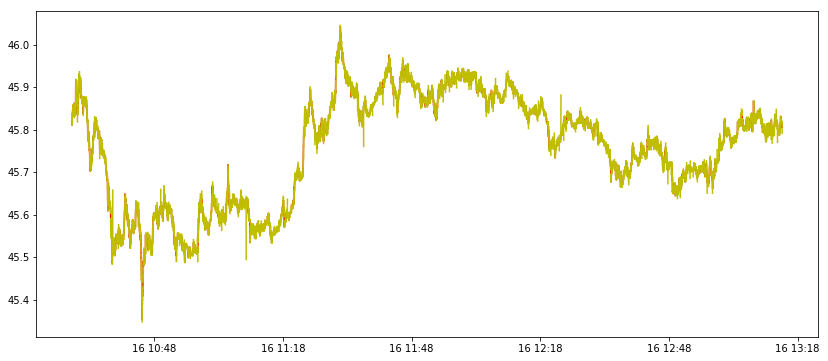

In [10]:
xaxis = list(pd.to_datetime(df_cv.index[1:]))
fig = plt.figure(figsize = [14, 6])
ax = fig.add_subplot(111)
_ = ax.plot(xaxis, 
            df_cv.iloc[1:]['Close'],
            'r-',
            label='market')
for i in range(len(X_pred)):
    _ = ax.plot([xaxis[i], xaxis[i+1]],
                [df_cv.iloc[i]['Close'], X_pred[i][0]], 
                'y-')
plt.show()

Zoomed in Views

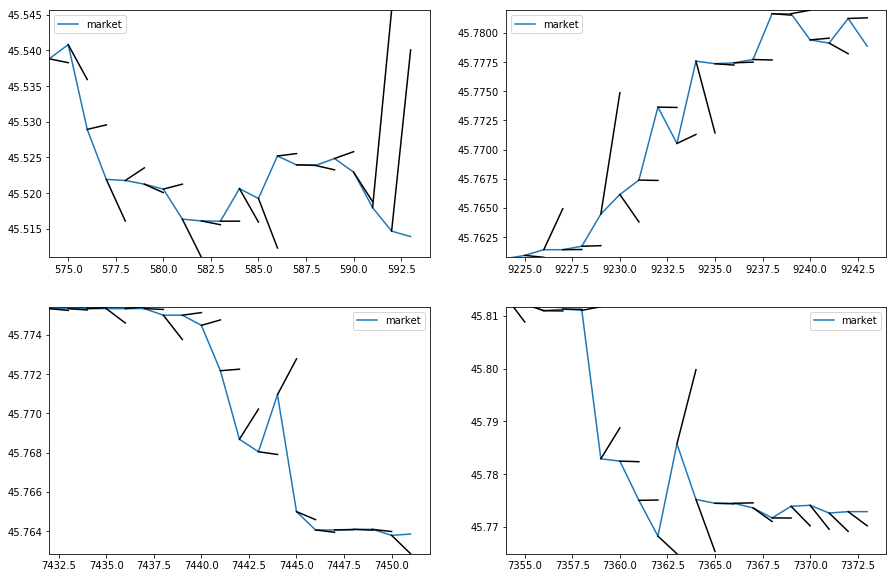

In [11]:
ax = [0] * 4
f, ((ax[0], ax[1]), (ax[2], ax[3])) = plt.subplots(2, 2, figsize=[15, 10])
for i in range(4):
    xmin = np.random.randint(1, len(df_cv)-20)
    xmax = xmin + 20
    ymin = np.min(X_pred[xmin:xmax])
    ymax = np.max(X_pred[xmin:xmax])
    _ = ax[i].axis([xmin, xmax, ymin, ymax])
    
    _ = ax[i].plot(range(xmin, xmax), 
                   df_cv.iloc[xmin:xmax]['Close'],
                   label='market')
    for j in range(xmin, xmax-1):
        _ = ax[i].plot([j, j+1],
            [df_cv.iloc[j]['Close'], X_pred[j-1]], 
            'k-')

    _ = ax[i].legend()
plt.show()

## Daily Data

In [12]:
'''
dfs = dfs.resample('24H', 
                   how={'High':'max', 'Low':'min', 'Close':'last'}, 
                   base=16,
                   loffset='1D',
                   convention='end').dropna()
'''

"\ndfs = dfs.resample('24H', \n                   how={'High':'max', 'Low':'min', 'Close':'last'}, \n                   base=16,\n                   loffset='1D',\n                   convention='end').dropna()\n"

In [13]:
df = pd.read_csv('D:\\daily.csv', index_col=0)

In [14]:
df.head()
df.tail()

,High,Low,Close
Date,,,
2016-11-01 16:00:00,47.350000,46.197164,46.340000
2016-11-02 16:00:00,46.470000,44.960000,45.495714
2016-11-03 16:00:00,45.904598,44.364398,44.657500
2016-11-04 16:00:00,44.870000,43.570000,44.125000
2016-11-07 16:00:00,45.010000,44.107500,44.956452


,High,Low,Close
Date,,,
2018-03-19 16:00:00,62.440000,61.450000,62.219000
2018-03-20 16:00:00,63.980000,62.130000,63.733333
2018-03-21 16:00:00,65.550000,63.580000,65.487778
2018-03-22 16:00:00,65.740000,64.139811,64.205000
2018-03-23 16:00:00,66.001837,64.110000,65.732459


In [15]:
# Create training data
train_index = len(df) * 90 // 100
df_train = df[:train_index]

p_open = np.asarray(df_train.ix[df_train.index[0]:df_train.index[-2]]['Close'])
p_close = np.asarray(df_train.ix[df_train.index[1]:]['Close'])
p_high = np.asarray(df_train.ix[df_train.index[1]:]['High'])
p_low = np.asarray(df_train.ix[df_train.index[1]:]['Low'])

n_features = 3
X_train = np.zeros([len(p_open), n_features])
X_train[:, 0] = (p_close - p_open) / p_open  # (close-open)/open
X_train[:, 1] = (p_high - p_open) / p_open  # (high-open)/open
X_train[:, 2] = (p_open - p_low) / p_open  # (open-low)/open

In [16]:
df_train.head()
df_train.tail()
df_train.shape

X_train[0:5]
X_train[-5:]
X_train.shape

,High,Low,Close
Date,,,
2016-11-01 16:00:00,47.350000,46.197164,46.340000
2016-11-02 16:00:00,46.470000,44.960000,45.495714
2016-11-03 16:00:00,45.904598,44.364398,44.657500
2016-11-04 16:00:00,44.870000,43.570000,44.125000
2016-11-07 16:00:00,45.010000,44.107500,44.956452


,High,Low,Close
Date,,,
2018-01-26 16:00:00,66.350000,64.910000,66.241500
2018-01-29 16:00:00,66.462931,64.973571,65.520984
2018-01-30 16:00:00,65.560000,63.890000,63.985000
2018-01-31 16:00:00,64.942151,63.670000,64.779167
2018-02-01 16:00:00,66.250000,64.630000,65.983333


(323, 3)

array([[-0.01821937,  0.00280535,  0.02977989],
       [-0.01842403,  0.0089873 ,  0.02486645],
       [-0.01192409,  0.00475844,  0.02435201],
       [ 0.0188431 ,  0.02005666,  0.0003966 ],
       [-0.00267121,  0.00964374,  0.01215513]])

array([[ 0.01526801,  0.01693097,  0.00513958],
       [-0.01087711,  0.00334278,  0.019141  ],
       [-0.02344262,  0.00059548,  0.02489254],
       [ 0.01241176,  0.01495898,  0.00492303],
       [ 0.0185888 ,  0.02270535,  0.0023027 ]])

(322, 3)

In [17]:
# Cross validation
cv_index = len(df) * 95 // 100
df_cv = df[train_index:cv_index]

p_open = np.asarray(df_cv.ix[df_cv.index[0]:df_cv.index[-2]]['Close'])
p_close = np.asarray(df_cv.ix[df_cv.index[1]:]['Close'])
p_high = np.asarray(df_cv.ix[df_cv.index[1]:]['High'])
p_low = np.asarray(df_cv.ix[df_cv.index[1]:]['Low'])

X_cv = np.zeros([len(p_open), n_features])
X_cv[:, 0] = (p_close - p_open) / p_open  # (close-open)/open
X_cv[:, 1] = (p_high - p_open) / p_open  # (high-open)/open
X_cv[:, 2] = (p_open - p_low) / p_open  # (open-low)/open

In [18]:
df_cv.head()
df_cv.tail()
df_cv.shape

X_cv[0:5]
X_cv[-5:]
X_cv.shape

,High,Low,Close
Date,,,
2018-02-02 16:00:00,66.300000,64.470000,65.050769
2018-02-05 16:00:00,65.407291,63.420000,63.439787
2018-02-06 16:00:00,64.291649,63.120000,63.924000
2018-02-07 16:00:00,64.180000,61.246951,61.735714
2018-02-08 16:00:00,62.090000,60.270000,60.424545


,High,Low,Close
Date,,,
2018-02-21 16:00:00,61.862692,60.916582,61.333750
2018-02-22 16:00:00,63.090000,60.750000,62.645625
2018-02-23 16:00:00,63.730000,62.330000,63.578710
2018-02-26 16:00:00,64.240000,63.059176,63.985000
2018-02-27 16:00:00,64.084444,62.635319,62.825714


(18, 3)

array([[-0.024765  ,  0.00548067,  0.02506918],
       [ 0.00763264,  0.01342788,  0.0050408 ],
       [-0.03423262,  0.00400476,  0.04187862],
       [-0.02123842,  0.00573875,  0.02374176],
       [-0.02289185,  0.00571712,  0.03896671]])

array([[-0.00389932,  0.00469105,  0.0106744 ],
       [ 0.02138912,  0.02863432,  0.0095176 ],
       [ 0.01489465,  0.01730967,  0.00503826],
       [ 0.00639035,  0.01040113,  0.0081715 ],
       [-0.01811809,  0.00155418,  0.02109371]])

(17, 3)

In [19]:
# Range of parameters
n_mix_params = [3, 4, 5, 6, 7, 8]
n_components_params = [3, 4, 5]

opt_params = get_params(n_mix_params, n_components_params, X_cv, df_cv)

3 3 CV error: 0.014476597764486633
3 4 CV error: 0.020839972881118878
3 5 CV error: 0.031125364211219517
4 3 CV error: 0.014535537186952979
4 4 CV error: 0.019820327413570607
4 5 CV error: 0.01436617880707362
5 3 CV error: 0.02232482802443559
5 4 CV error: 0.01977015396414754
5 5 CV error: 0.01831500338645796
6 3 CV error: 0.021817652398041357
6 4 CV error: 0.014932007609169271
6 5 CV error: 0.01931787576122499
7 3 CV error: 0.021845398772117344
7 4 CV error: 0.021735605431752555
7 5 CV error: 0.010997826319769647
8 3 CV error: 0.019103585864693535
8 4 CV error: 0.022864876515262582
8 5 CV error: 0.021392270789678394


In [20]:
n_mix, n_components = opt_params
hmm = GMMHMM(n_components=n_components,
             n_mix=n_mix)
_ = hmm.fit(X_train)
hmm.transmat_

n_samples = 9
X_pred = sample(hmm, X_cv, df_cv, n_samples=n_samples)

array([[0.0527025 , 0.27415944, 0.08925556, 0.32547558, 0.25840693],
       [0.05661742, 0.13761172, 0.2024982 , 0.26123185, 0.34204082],
       [0.04128749, 0.31752544, 0.09007435, 0.27350344, 0.27760928],
       [0.07471685, 0.32204982, 0.06046233, 0.23617345, 0.30659755],
       [0.07671965, 0.19069926, 0.18244069, 0.23667116, 0.31346924]])

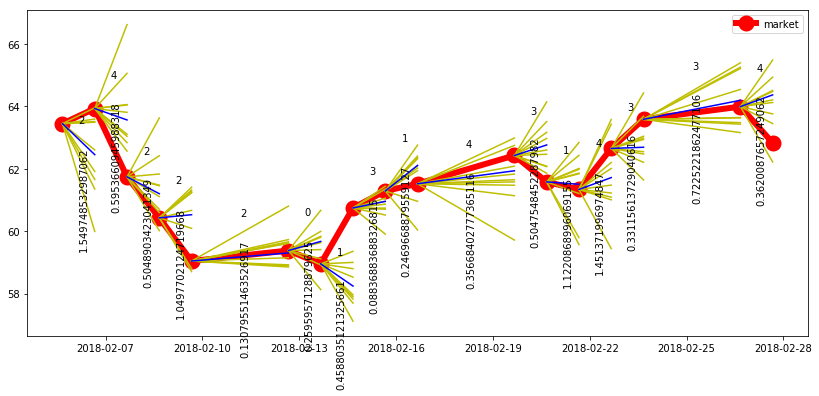

In [27]:
xaxis = list(pd.to_datetime(df.index[train_index+1:cv_index]))
fig = plt.figure(figsize = [14, 6])
ax = fig.add_subplot(111)
_ = ax.plot(xaxis, 
            df.iloc[train_index+1:cv_index]['Close'],
            'r-',
            linewidth=6,
            label='market',
            marker='o',
            mew=10)
for i in range(len(X_pred)):
    for j in range(n_samples):
        _ = ax.plot([xaxis[i], xaxis[i+1]],
                    [df_cv.iloc[1+i]['Close'], X_pred[i, j]], 
                    'y-')

    non_outliers = X_pred[i][abs(X_pred[i] - np.mean(X_pred[i])) < 2 * np.std(X_pred[i])]
    # Display variance of non-outliers
    _ = ax.text(mdates.date2num(xaxis[i] + (xaxis[i+1] - xaxis[i])/2), 
                np.mean(X_pred[i]), 
                str(np.var(non_outliers)),
                rotation='vertical')
    # Display mean of non-outliers
    _ = ax.plot([xaxis[i], xaxis[i+1]],
            [df_cv.iloc[1+i]['Close'], np.mean(non_outliers)], 
            'b-')
    # Display state
    _ = ax.text(mdates.date2num(xaxis[i] + (xaxis[i+1] - xaxis[i])/2), 
                np.mean(X_pred[i])+1,
                hmm.predict(X_cv)[i])
_ = ax.legend()
plt.show()
